# 프로젝트: CutMix 또는 Mixup 비교실험 하기

## 0. 데이터 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

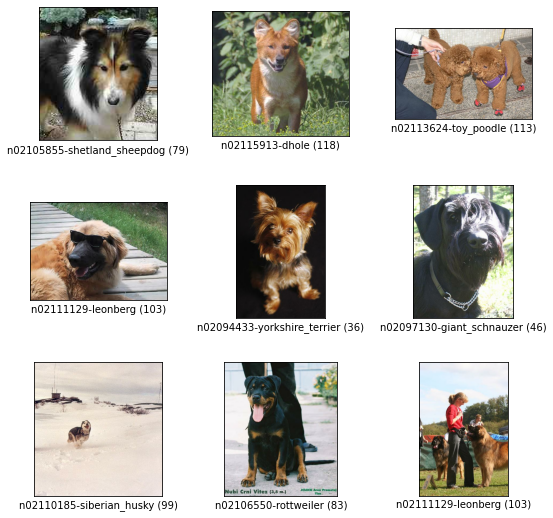

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

## 1. Augmentation을 적용한 데이터셋 만들기

In [4]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

In [5]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three], axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [6]:
# mix two labels
def mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa) * (yb-ya)
    total_area = image_size_x * image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [7]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [8]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [9]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [36]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

In [12]:
def onehot(image, label, num_classes=120):
    label = tf.one_hot(label, num_classes)
    return image, label

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
num_classes = ds_info.features["label"].num_classes

In [37]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 2. 모델 만들기

In [16]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [38]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [18]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [19]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## 3. 모델 훈련하기

In [31]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 30
BATCH_SIZE = 16

In [39]:
tf.random.set_seed(42)

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [22]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 110s 146ms/step - loss: 2.1808 - accuracy: 0.4498 - val_loss: 3.5223 - val_accuracy: 0.1858
Epoch 2/30
750/750 [==============================] - 110s 146ms/step - loss: 0.7950 - accuracy: 0.7738 - val_loss: 1.3671 - val_accuracy: 0.6051
Epoch 3/30
750/750 [==============================] - 111s 148ms/step - loss: 0.2656 - accuracy: 0.9423 - val_loss: 0.9525 - val_accuracy: 0.7208
Epoch 4/30
750/750 [==============================] - 110s 147ms/step - loss: 0.1221 - accuracy: 0.9808 - val_loss: 0.9218 - val_accuracy: 0.7312
Epoch 5/30
750/750 [==============================] - 111s 148ms/step - loss: 0.0562 - accuracy: 0.9942 - val_loss: 0.9303 - val_accuracy: 0.7341
Epoch 6/30
750/750 [==============================] - 111s 148ms/step - loss: 0.0319 - accuracy: 0.9970 - val_loss: 0.9286 - val_accuracy: 0.7450
Epoch 7/30
750/750 [==============================] - 112s 149ms/step - loss: 0.0171 - accuracy: 0.9987 - val_loss: 0.9179 -

In [40]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 110s 146ms/step - loss: 2.2178 - accuracy: 0.4420 - val_loss: 4.1483 - val_accuracy: 0.1128
Epoch 2/30
750/750 [==============================] - 110s 147ms/step - loss: 0.9152 - accuracy: 0.7347 - val_loss: 1.2005 - val_accuracy: 0.6523
Epoch 3/30
750/750 [==============================] - 110s 147ms/step - loss: 0.5173 - accuracy: 0.8546 - val_loss: 1.1485 - val_accuracy: 0.6763
Epoch 4/30
750/750 [==============================] - 110s 147ms/step - loss: 0.2982 - accuracy: 0.9232 - val_loss: 1.0348 - val_accuracy: 0.7020
Epoch 5/30
750/750 [==============================] - 110s 147ms/step - loss: 0.1563 - accuracy: 0.9674 - val_loss: 1.0218 - val_accuracy: 0.7065
Epoch 6/30
750/750 [==============================] - 110s 147ms/step - loss: 0.1015 - accuracy: 0.9813 - val_loss: 0.9562 - val_accuracy: 0.7324
Epoch 7/30
750/750 [==============================] - 109s 146ms/step - loss: 0.0650 - accuracy: 0.9908 - val_loss: 0.9611 -

In [24]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 112s 149ms/step - loss: 3.8222 - accuracy: 0.2068 - val_loss: 3.3029 - val_accuracy: 0.2261
Epoch 2/30
750/750 [==============================] - 111s 148ms/step - loss: 2.9409 - accuracy: 0.4309 - val_loss: 1.4665 - val_accuracy: 0.5903
Epoch 3/30
750/750 [==============================] - 111s 148ms/step - loss: 2.6394 - accuracy: 0.5351 - val_loss: 1.2380 - val_accuracy: 0.6495
Epoch 4/30
750/750 [==============================] - 111s 148ms/step - loss: 2.4332 - accuracy: 0.6014 - val_loss: 1.2601 - val_accuracy: 0.6586
Epoch 5/30
750/750 [==============================] - 111s 148ms/step - loss: 2.2883 - accuracy: 0.6462 - val_loss: 1.2929 - val_accuracy: 0.6444
Epoch 6/30
750/750 [==============================] - 111s 148ms/step - loss: 2.2109 - accuracy: 0.6707 - val_loss: 1.1966 - val_accuracy: 0.6798
Epoch 7/30
750/750 [==============================] - 111s 148ms/step - loss: 2.1102 - accuracy: 0.7053 - val_loss: 1.1610 -

In [25]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 113s 151ms/step - loss: 3.6959 - accuracy: 0.2428 - val_loss: 4.1987 - val_accuracy: 0.1084
Epoch 2/30
750/750 [==============================] - 112s 150ms/step - loss: 2.8527 - accuracy: 0.4773 - val_loss: 1.4099 - val_accuracy: 0.6098
Epoch 3/30
750/750 [==============================] - 112s 150ms/step - loss: 2.5669 - accuracy: 0.5834 - val_loss: 1.1848 - val_accuracy: 0.6589
Epoch 4/30
750/750 [==============================] - 112s 150ms/step - loss: 2.3947 - accuracy: 0.6555 - val_loss: 1.2685 - val_accuracy: 0.6461
Epoch 5/30
750/750 [==============================] - 112s 150ms/step - loss: 2.2923 - accuracy: 0.6935 - val_loss: 1.3361 - val_accuracy: 0.6393
Epoch 6/30
750/750 [==============================] - 112s 150ms/step - loss: 2.1814 - accuracy: 0.7351 - val_loss: 1.2879 - val_accuracy: 0.6588
Epoch 7/30
750/750 [==============================] - 112s 150ms/step - loss: 2.0955 - accuracy: 0.7673 - val_loss: 1.1310 -

## 4. 훈련 과정 시각화하기

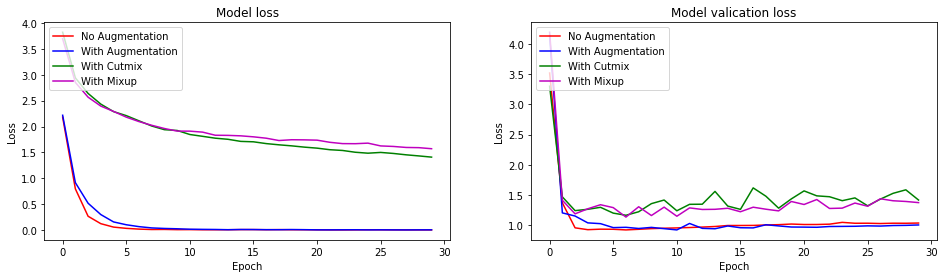

In [41]:
fig = plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_cutmix.history['loss'], 'g')
plt.plot(history_resnet50_mixup.history['loss'], 'm')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm')
plt.title('Model valication loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

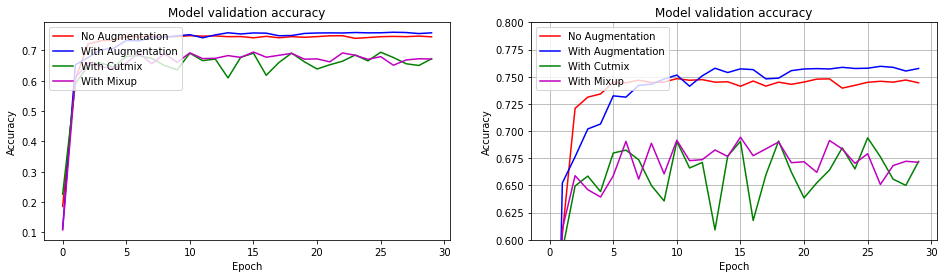

In [43]:
fig = plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.80)
plt.show()

- Tensorflow에 있는 여러가지 Augmentation 함수들을 이용하여 훈련을 시켜본 결과, flip만 시킨 결과가 가장 좋았다.
- Cutmix와 Mixup은 오히려 성능이 떨어졌다.

## 회고록

- cutmix나 mixup과 같은 Augmentation 기법들이 모델의 성능을 향상시키는데 도움을 준다고는 하는데, 과연 사실일지 직접 실험해볼 수 있게 되었다.
- 실제로 실험을 해보니 아무것도 하지 않거나 filp정도만 한 결과가 가장 좋게 나왔다.
- 다른 여러가지 augmentation 기법을 적용해봤는데 결국 filp만 한 결과가 가장 좋았다.
- cutmix의 경우 object를 판단할 수 있는 위치가 아닌 전혀 상관없는 부분이 선택된다면 오히려 정확도 하락을 가져올 것이다. 이 부분은 cutmix의 영역을 제한하는 방법으로 해결할 수 있을 것 같다.
- 실제로 논문에서도 cutmix와 mixup을 이용했을 땐 2%정도의 향상밖에 없었는데 어떻게 5%를 올릴 수 있는지 모르겠다. 가능한건가?